## Load the fama french dataset

In [ ]:
import sys
sys.path.append('../src')

from data_loader import load_sector_data, get_seasonal_returns, calculate_sector_ratio

from timeseries_analysis import (
    reshape_to_timeseries,
    calculate_sp500_returns_ts,
    calculate_smga_returns_ts,
)

from fama_french_analysis import (
    run_fama_french_regression,
    print_regression_summary,
    plot_regression_diagnostics,
    plot_factor_loadings,
    plot_alpha_comparison,
    plot_rolling_alpha,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import pandas as pd

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Setup complete!")

✓ Setup complete!


## load up fama factors for regression

In [2]:
# loading data and converting into reusable ff factors regression input

# Load the data
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'
factor_series = {}
factor_skiprows = [(1, "Mkt-RF"), (59, "SMB"), (117, "HML"), (175, "rf")]
for skiprows, factor in factor_skiprows:
    df_monthly = load_sector_data(file_path, "SMB_HML", skiprows, numrows=56)
    ts = reshape_to_timeseries(df_monthly).sort_index()
    ts = pd.to_numeric(ts, errors="coerce")  # ensure numeric
    ts.name = factor
    factor_series[factor] = ts
factors_df = pd.concat(factor_series.values(), axis=1)
factors_df.index.name = "Date"

display(factors_df.head())


,Mkt-RF,SMB,HML,rf
Date,,,,
1970-01-01,-8.100,2.910,3.170,0.600
1970-02-01,5.140,-2.390,3.690,0.620
1970-03-01,-1.060,-2.310,4.080,0.570
1970-04-01,-10.990,-6.140,6.140,0.500
1970-05-01,-6.900,-4.610,3.320,0.530


## load up datasets we want to run regressions on

In [3]:
df_sp500 = load_sector_data(file_path, 'S&P500')
df_tbills = load_sector_data(file_path, 'TBills')

print("SP 500 data:")
print(f"  Years: {df_sp500.index.min()} - {df_sp500.index.max()}")
print(f"  Shape: {df_sp500.shape}")

print("\nTbills data:")
print(f"  Years: {df_tbills.index.min()} - {df_tbills.index.max()}")
print(f"  Shape: {df_tbills.shape}")


sp500_excess = calculate_sp500_returns_ts(df_sp500, df_tbills)
print(f"\nS&P 500 excess returns calculated")
print(f"Total observations: {len(sp500_excess)}")
print(f"Date range: {sp500_excess.index.min()} to {sp500_excess.index.max()}")

smga_excess = calculate_smga_returns_ts(df_sp500, df_tbills)

print(f"\nSMGA excess returns calculated")
print(f"Total observations: {len(smga_excess)}")
print(f"Date range: {smga_excess.index.min()} to {smga_excess.index.max()}")



SP 500 data:
  Years: 1970 - 2025
  Shape: (56, 12)

Tbills data:
  Years: 2001 - 2025
  Shape: (25, 12)

S&P 500 excess returns calculated
Total observations: 291
Date range: 2001-08-01 00:00:00 to 2025-10-01 00:00:00

SMGA excess returns calculated
Total observations: 291
Date range: 2001-08-01 00:00:00 to 2025-10-01 00:00:00


## Run fama regression

In [7]:
# sp500 regression
results_sp500 = run_fama_french_regression(sp500_excess, ff_factors=factors_df)
print("SP500 regression results")
print("========================")
print_regression_summary(results_sp500, "S&P500")

# sp500 regression
results_smga = run_fama_french_regression(smga_excess, ff_factors=factors_df)
print("\nSMGA regression results")
print("========================")
print_regression_summary(results_smga, "S&P500")


            Strategy  Mkt-RF    SMB    HML    RF
2001-08-01    -6.696  -6.400  2.190  2.860 0.310
2001-09-01    -8.389  -9.240 -6.230  1.520 0.280
2001-10-01     1.625   2.480  7.490 -7.310 0.220
2001-11-01     7.356   7.530 -0.570  2.170 0.170
2001-12-01     0.618   1.610  4.720  0.830 0.150
2002-01-01    -1.693  -1.440  1.170  3.420 0.140
2002-02-01    -2.218  -2.300 -1.080  2.340 0.130
2002-03-01     3.529   4.240  4.090  1.080 0.130
2002-04-01    -6.282  -5.210  5.820  4.010 0.150
2002-05-01    -1.050  -1.360 -3.270  1.520 0.140
SP500 regression results
FAMA-FRENCH REGRESSION RESULTS: S&P500

Alpha (Monthly):      -0.1566%  (p=0.0000)
Alpha (Annual):       -1.8794%
Significance:         ***

Factor Loadings:
  Market (Beta):       0.9901  (p=0.0000)
  SMB (Size):         -0.1427  (p=0.0000)
  HML (Value):         0.0118  (p=0.0295)

Model Fit:
  R-squared:           0.9959
  Adj. R-squared:      0.9958
  Observations:           290

            Strategy  Mkt-RF    SMB    HML    RF


## Plot regression

S&P500 plots


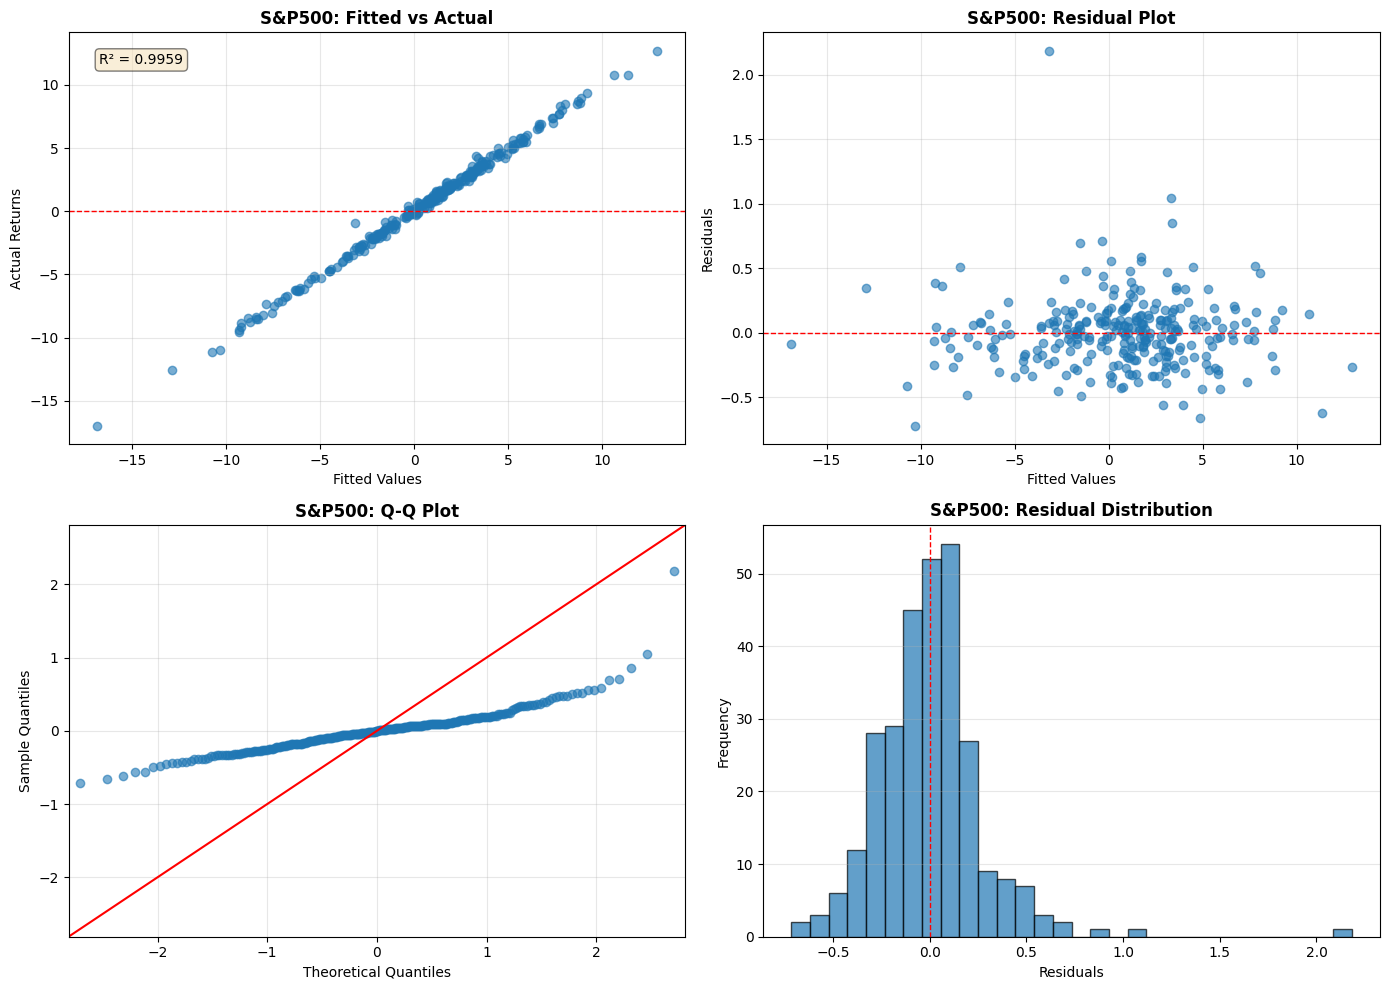

S&P500 plots


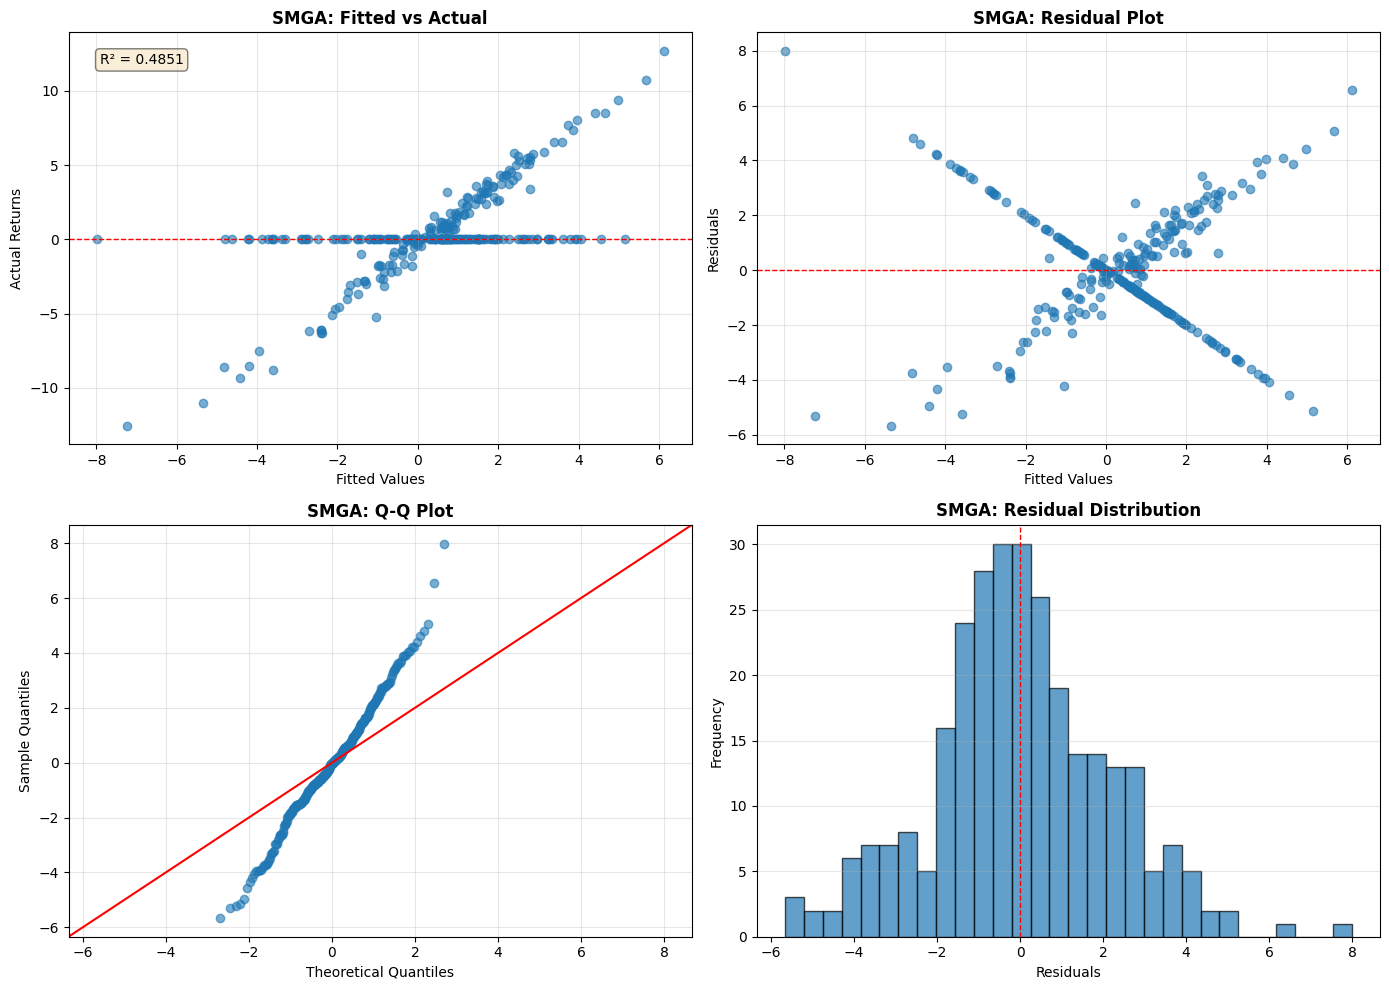

In [11]:
print("========================")
print("S&P500 plots")
print("========================")
plot_regression_diagnostics(sp500_excess, results_sp500, "S&P500")

print("========================")
print("S&P500 plots")
print("========================")
plot_regression_diagnostics(smga_excess, results_smga, "SMGA")